In [54]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [55]:
import os
import csv
import numpy as np
import tensorflow as tf
from google.colab import files
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import NumpyArrayIterator


In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)


In [56]:
# Origin definition of 25 signs which the finger can represent is at kaggle.com:
# https://www.kaggle.com/datamunge/sign-language-mnist/home
# Here is the direct download linke which can ease the training task.

test_data  = "https://dl.dropbox.com/s/awxlruqspsyv8qx/sign_mnist_test.csv"
train_data = "https://dl.dropbox.com/s/aj9maocoap59i14/sign_mnist_train.csv"

R_PATH = "/tmp" # Host directory to put downloads
test_file = os.path.join(R_PATH, "sign_mnist_test.csv")
train_file = os.path.join(R_PATH, "sign_mnist_train.csv")


In [57]:
def download_file(source, dest_dir):
    """Download file
    :param source: Location of source file.
    :param dest_dir: Location to put downloaded file, the extract place is the same otherwise.
    """
    assert (dest_dir is not None)
    from tensorflow.python.keras.utils.data_utils import get_file

    print(f"Download to {dest_dir}")
    return get_file(fname=dest_dir, origin=source)


In [58]:
f = download_file(test_data, f"{R_PATH}/sign_mnist_test.csv")
print(f"Just downloaded: {f}")

f = download_file(train_data, f"{R_PATH}/sign_mnist_train.csv")
print(f"Just downloaded: {f}")


Download to /tmp/sign_mnist_test.csv
Just downloaded: /tmp/sign_mnist_test.csv
Download to /tmp/sign_mnist_train.csv
Just downloaded: /tmp/sign_mnist_train.csv


In [59]:
def get_data(filename):
  assert (filename is not None)

  with open(filename) as f:
    reader = csv.reader(f, delimiter=",")
    next(reader)

    images = []
    labels = []
    for row in reader:
      labels.append(row[0])

      px = row[1:785]
      ma_px = np.array_split(px, 28)
      images.append(ma_px)

    return np.array(images).astype(float), np.array(labels).astype(int)
    

In [60]:
training_images, training_labels = get_data(train_file)
testing_images, testing_labels = get_data(test_file)

# Keep these
print(training_images.shape)
print(training_labels.shape)
print(testing_images.shape)
print(testing_labels.shape)

# Their output should be:
# (27455, 28, 28)
# (27455,)
# (7172, 28, 28)
# (7172,)

(27455, 28, 28)
(27455,)
(7172, 28, 28)
(7172,)


In [61]:
training_images = np.expand_dims(training_images, axis=-1)
testing_images = np.expand_dims(testing_images, axis=-1)

# Create an ImageDataGenerator and do Image Augmentation
train_datagen = ImageDataGenerator(
    rescale = 1./255.,
    horizontal_flip=True, 
    vertical_flip=True,
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    shear_range=0.1, 
    zoom_range=0.1, 
)

training_data = NumpyArrayIterator(x=training_images, y=training_labels, 
                                   image_data_generator=train_datagen)

validation_datagen = ImageDataGenerator(
    rescale = 1./255.
)

validation_data = NumpyArrayIterator(x=testing_images, y=testing_labels,
                                     image_data_generator=validation_datagen)

# Keep These
print(training_images.shape)
print(testing_images.shape)
    
# Their output should be:
# (27455, 28, 28, 1)
# (7172, 28, 28, 1)

(27455, 28, 28, 1)
(7172, 28, 28, 1)


In [62]:
# Define the model
model = tf.keras.models.Sequential([ 
  tf.keras.layers.Conv2D(filters=32, kernel_size=4,   
                         input_shape=[28, 28, 1],  
                         activation=tf.keras.activations.relu),
  tf.keras.layers.MaxPool2D(pool_size=2, padding="valid"), 

  tf.keras.layers.Conv2D(filters=64, kernel_size=3,   
                         activation=tf.keras.activations.relu),
  tf.keras.layers.MaxPool2D(pool_size=2, padding="valid"), 

  tf.keras.layers.Conv2D(filters=128, kernel_size=3,   
                         activation=tf.keras.activations.relu),
  tf.keras.layers.MaxPool2D(pool_size=2, padding="valid"), 

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(units=48, activation=tf.keras.activations.relu   ), 
  tf.keras.layers.Dense(units=25, activation=tf.keras.activations.softmax)
])

# Compile Model. 
model.compile(optimizer=tf.keras.optimizers.RMSprop(), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics=['accuracy'])
model.summary()

# Train the Model
history = model.fit(training_data, 
                    validation_data=validation_data,
                    epochs=100)

model.evaluate(validation_data)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 25, 25, 32)        544       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 3, 3, 128)         73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)              

[0.07620953768491745, 0.9863357543945312]

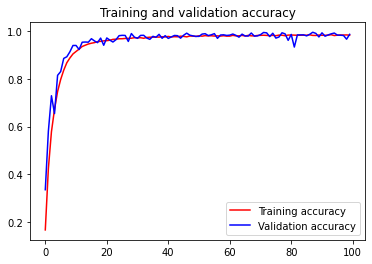

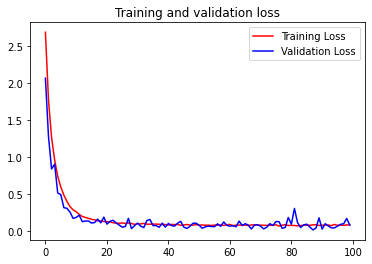

In [63]:
# Plot the chart for accuracy and loss on both training and validation

import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
